# SWIM: Stellar Wind and Irradiance Module

Created on June 6th 2022 @ 3rd Eddy Cross Disciplinary Symposium, Vail, CO, USA.
Code based on original idea by Dan Marsh (NCAR, University of Leeds).

## Authors and contributers:

Gregory Cooke (University of Leeds, pygjc@leeds.ac.uk),
Allison Youngblood (NASA Goddard),
Caitlin Gough (University of Leeds),
James Colliander (University of British Columbia),
Fernando Pérez (University of California, Berkeley),
Meng Jin (Lockheed Martin Solar & Astrophysics Lab / SETI Institute),
and Dan Marsh (NCAR, University of Leeds)

## Description:
Code to read in files from the MUSCLES database and scale them to be used in various atmospheric models for different planets in those stellar systems.

## User Guide:

Run each cell until drop down menus appear.
Select your desired options from dropdown menus.
A file with wavelength and flux will be saved out.
This is a .nc (netCDF file) for CAM/WACCM, for example.

## To do list (community input required)
- Add in stellar wind models
- Add in protoplanetary disk models
- Add different climate model wavelength grids (only WACCM, ROCKE-3D, and custom grids so far)
- These wavelength grids are not known to us (we could not find them)
- Add in different ways to save the data (e.g. files such as .csv, .txt etc.) to be compatable with different models

## Import required modules

In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from ipywidgets import interactive
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
import json
import os
from scipy.integrate import trapz
from astropy.io import fits

#download spectres uncomment next line if spectres not installed
os.system('pip install spectres')
#import spectres 
import spectres as sp

# SWIM functions
from util import download_data, sub, sup
from climate_models import model_spectrum

## Program options begin here
### Access the MUSCLES database

In [2]:
# MUSCLES data type selection

# dictionary relating data type to json file
# json files contain the web address in the archive of each star
Data_Types = {'Constant native resolution': 'json/stellar_names_const_adapt.json',
              'Variable native resolution': 'json/stellar_names_const_adapt.json',
              'Constant adaptive resolution': 'json/stellar_names_var_adapt.json',
              'Variable adaptive resolution': 'json/stellar_names_var_native.json'}

# create a drop down menu to select data type from MUSCLES files
style = {'description_width': 'initial'}
data_type = widgets.Dropdown( options=(Data_Types),
                             description='Data type selection',
                             style=style,
                             disabled=False)

display(data_type)

Dropdown(description='Data type selection', options={'Constant native resolution': 'json/stellar_names_const_a…

### Select MUSCLES star

In [3]:
#reads in json file with MUSCLES archive list 

json_file = data_type.value
stellar_names_and_data = json.load(open(json_file))

# create a drop down menu to choose star in MUSCLES database
MUSCLES_files = widgets.Dropdown(options=(stellar_names_and_data),
                                 description='MUSCLES stellar object:',
                                 style=style,
                                 disabled=False)

display(MUSCLES_files)

Dropdown(description='MUSCLES stellar object:', options={'GJ 1132': 'https://archive.stsci.edu/missions/hlsp/m…

## Read in MUSCLES data and assign to arrays

In [4]:
#get star name
star_name = [k for k, v in stellar_names_and_data.items() if v == MUSCLES_files.value][0]

# downloade the stars fits file
fits_file = download_data(MUSCLES_files.value)

# read the starts spectrum
print(fits_file)
spec = fits.getdata(fits_file,1)

#convert to mW/m2/nm
per_cm2_to_per_m2 = 100**2
erg_per_s_to_mW = 1e-4
per_Ang_to_per_nm = 10.

New_flux = spec['FLUX'] * erg_per_s_to_mW * per_cm2_to_per_m2 * per_Ang_to_per_nm

# may need to change for different models
Wavelength = spec['WAVELENGTH']*0.1

# read in or create the output model grid and spectrum
Irradiance_at_Earth = 1360000 # TSI? mW/m2? 
xlim = (10,1e5) # xlim for plots

hlsp_muscles_multi_multi_gj1132_broadband_v23_adapt-const-res-sed.fits already downloaded
./fits/hlsp_muscles_multi_multi_gj1132_broadband_v23_adapt-const-res-sed.fits


## Select climate model for output

In [5]:
# Other climate models can be included
# Please email Greg Cooke at pygjc@leeds.ac.uk

Climate_model_list = ['None selected','WACCM', 
                      'CAM', 
                      'ExoCam', 
                      'UM', 
                      'LMD-G', 
                      'ROCKE-3D', 
                      'CCSM3', 
                      'Atmos', 
                      'Custom constant grid', 
                      'Custom variable grid'
                     ]

Climate_model_selection = widgets.Dropdown(options=Climate_model_list,
                                           description='Select climate model',
                                           disabled=False)
caption = widgets.Label(value='Please select model')
Climate_model_selection = widgets.Dropdown(options=Climate_model_list,
                                           description='Select climate model',
                                           disabled=False)
def dropdown_change(change):
    global model
    model = Climate_model_selection.value
    print('Target model:', model)
    
Climate_model_selection.observe(dropdown_change, names='value')
model = display(caption, Climate_model_selection)

Label(value='Please select model')

Dropdown(description='Select climate model', options=('None selected', 'WACCM', 'CAM', 'ExoCam', 'UM', 'LMD-G'…

Target model: WACCM


In [6]:
if(model == 'Custom constant grid'):
    print('Please enter starting wavelength in nm')
    a = float(input())
    print('Please enter final wavelength in nm')
    b = float(input())
    print('Please enter wavelength binning in nm')
    c = float(input())
    model_wavelength = np.arange(a,b+c,c)
    
elif(model == 'Custom variable grid'):
    print('NOTE: the current functionality is to read in a text ')
    print('file of wavelength vs flux\nusing np.genfromtxt(filename).')
    print('Please enter the file name of the custom wavelength grid')
    #get file name
    file_name = input()
    #get wavelength multiplier
    print('Please enter the multiplier for the wavelength in order to convert to nm')
    multiplier = float(input())

    Input_file = np.genfromtxt(file_name)
    model_wavelength = Input_file[:,0]*multiplier
    model_flux = Input_file[:,1]

else:
    model_flux, model_wavelength, starlabel, flux_units = model_spectrum(model)
    
# find total stellar irradiance from file
# get total stellar irradiance at top of atmosphere

TSI_spectra = trapz(New_flux, Wavelength)
print('Total stellar irradiance from original file relative to the Sun: '+ str(TSI_spectra/Irradiance_at_Earth))

# scale TSI
Scaled_flux_to_Earth = New_flux/(TSI_spectra/Irradiance_at_Earth)
TSI_spectra = trapz(Scaled_flux_to_Earth, Wavelength)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/Irradiance_at_Earth))

File already downloaded
Total stellar irradiance from original file relative to the Sun: 6.949514515971132e-16
Scaled total stellar irradiance relative to the Sun: 1.0000000000000004


## Access the Exoplanet Archive and choose exoplanet

In [7]:
# read in only the following rows from the NASA exoplanet archive:
# pl_name, hostname, st_lum, pl_orbsmax, st_teff, rowupdate

url = 'https://exoplanetarchive.ipac.caltech.edu/TAP/sync'
query = '?query=select+pl_name,hostname,st_lum,pl_orbsmax,st_teff,rowupdate+from+ps&format=csv'
NASA_Exo_Archive = pd.read_csv(url+query)

# set Spectra_name_same_as_host_name = False if looking at exoplanets around a different 
# star to the ones in the MUSCLES database, i.e., if you want spectra for an M8 star but 
# the closest spectra availiable is TRAPPIST-1 otherwise in this example you will only be
# able to select TRAPPIST-1 planets if Spectra_name_same_as_host_name = True

Spectra_name_same_as_host_name = True

#Find planets based on host name
if (Spectra_name_same_as_host_name):
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == star_name]['pl_name']
    Find_planets = widgets.Dropdown(options=planets.drop_duplicates(),
                                    description='Find planets',
                                    disabled=False)
    display(Find_planets)
else:
    Find_host = widgets.Dropdown(options=(NASA_Exo_Archive['hostname'].drop_duplicates()),
                                 description='Find host',
                                 disabled=False)
    display(Find_host)
    
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == Find_host.value]['pl_name']
    Find_planets = widgets.Dropdown(options=planets,
                                    description='Find planets',
                                    disabled=False)
    display(Find_planets)

Dropdown(description='Find planets', options=('GJ 1132 b', 'GJ 1132 c'), value='GJ 1132 b')

## Rebin spectra to target model and rescale to exoplanet irradiance

In [8]:
# drop nan rows for luminosity and orbital period
planet_name = Find_planets.value
pl = NASA_Exo_Archive.\
    loc[NASA_Exo_Archive['pl_name'] == planet_name].\
    dropna(subset=['st_lum','pl_orbsmax'])

#rebin and perform final rescaling
from Rebin_rescale_spectra import rebin_rescale
Final_scaled_flux, flux_relative_to_Earth = rebin_rescale(Wavelength = Wavelength,
                                                          model_wavelength = model_wavelength, 
                                                          model = model, 
                                                          Scaled_flux_to_Earth = Scaled_flux_to_Earth,
                                                          starlabel = starlabel, pl = pl,
                                                          planet_name = planet_name)

semi-major axis of GJ 1132 b = 0.0153 AU
Star has 0.004375221051582521 times luminosity of Sun
GJ 1132 b recieves 18.690337270205994 times flux recieved by Earth

Total stellar irradiance from Sun spectra is: 1359943.3 mW/m^2
Scaled total stellar irradiance relative to the Sun: 18.68955800576663


## Plot scaled stellar spectra

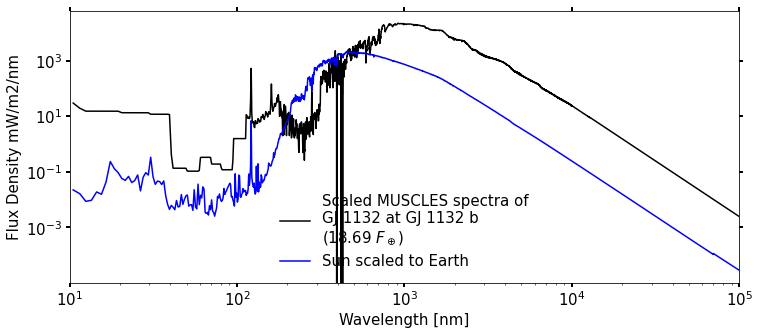

In [9]:
label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' +\
         Find_planets.value+'\n(' +\
         str(round(flux_relative_to_Earth,3)) + ' ' + r'$F_\oplus$'+')'

from Plot_spectrum import plot_spectrum
plot_spectrum(wav1 = model_wavelength, flux1 = Final_scaled_flux, wav2 = model_wavelength, flux2 = model_flux, 
              number = 2, flux_units = flux_units,
              label1 = label, label2 = starlabel+' scaled to Earth', xlim = (10,1e5))

## Save spectrum to file

In [10]:
#now write out the files to the working directory
if (model == 'WACCM' or model == 'CAM'):
    ds = xr.open_dataset('SolarForcingCMIP6piControl_c160921.nc')
    ds.ssi.values[0] = Final_scaled_flux; ds.ssi.values[1] = Final_scaled_flux
    NewFile = 'TOA_Flux_at_'+Find_planets.value+'_for_'+Climate_model_selection.value+'.nc'
    NewFile = NewFile.replace(" ", "_")
    ds.to_netcdf('./output/'+NewFile)
    print('File saved')
elif (model == 'ROCKE-3D'):
    # does ROCKE-3D need to be scaled back to W/m2/m and grid on m?
    # clearly negative fluxes mean something is wrong here!
    NewFile = 'TOA_Flux_at_'+Find_planets.value+'_for_'+Climate_model_selection.value
    NewFile = NewFile.replace(" ", "_")
    df = pd.DataFrame(data={'Wavelength [m]': model_wavelength, 'Flux [W/m^3]':  Final_scaled_flux})
    df.to_csv('./output/'+NewFile+'.txt', index = False)
    print('File saved')
elif (model == 'Atmos'):
    NewFile = 'TOA_Flux_at_'+Find_planets.value+'_for_'+Climate_model_selection.value
    NewFile = NewFile.replace(" ", "_")
    df = pd.DataFrame(data={'Wavelength [m]': model_wavelength, 'Flux [W/m^3]':  Final_scaled_flux})
    df.to_csv('./output/'+NewFile+'.txt', index = False)
    print('File saved')
else:
    print('File not saved')

File saved


## Clean up directory

In [11]:
# clean up
# remove MUSCLES files in current directory
os.system('rm fits/*muscles*.fits')

0